# Instructions
- Some parts of the code are already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

# Face detection
Task is to predict the boundaries(mask) around the face in a given image.


## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### Change current working directory to project folder (1 mark)

In [0]:
import os
os.chdir('/content/drive/My Drive/MyColabProjects/9.32.5_FaceDetection')

### Load the "images.npy" file (4 marks)
- This file contains images with details of bounding boxes

In [0]:
import numpy as np
data = np.load('/content/drive/My Drive/MyColabProjects/9.32.5_FaceDetection/images.npy', encoding='bytes', allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (4 marks)

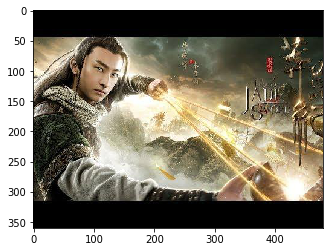

In [8]:
from matplotlib import pyplot as plt

plt.imshow(data[21][0])
plt.show()

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [0]:
HEIGHT_CELLS = 28
WIDTH_CELLS = 28

# CELL_WIDTH = IMAGE_WIDTH / WIDTH_CELLS
# CELL_HEIGHT = IMAGE_HEIGHT / HEIGHT_CELLS

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Print the shape of X_train and mask array  (1 mark)

In [64]:
X_train.shape

(409, 224, 224, 3)

In [65]:
masks.shape

(409, 224, 224)

### Print a sample image and image array

[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

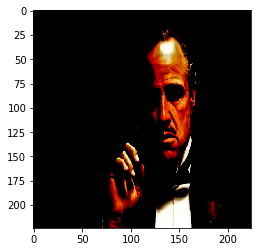

In [66]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])

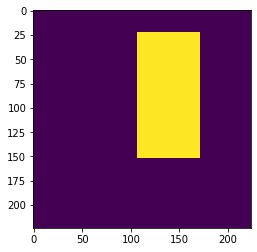

In [67]:
pyplot.imshow(masks[n])

## Create the model (10 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights='imagenet')    # Load pre-trained mobilenet    
    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output

    
    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(4, kernel_size=1, activation="sigmoid",padding='SAME')(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)


    return Model(inputs=model.input, outputs=x)


### Call the create_model function

In [69]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model()

# Print summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
____________________________________________________________________________________________

### Define dice coefficient function (5 marks)
- Create a function to calculate dice coefficient

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compile the model (5 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [0]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model (5 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [74]:
model.fit(X_train, masks, batch_size = 1, epochs = 20, callbacks=[checkpoint, reduce_lr, stop])

Train on 409 samples
Epoch 1/20
408/409 [============================>.] - ETA: 0s - loss: 1.9074 - dice_coefficient: 0.2984
Epoch 00001: loss improved from inf to 1.90640, saving model to model-1.91.h5
409/409 [==============================] - 30s 72ms/sample - loss: 1.9064 - dice_coefficient: 0.2984
Epoch 2/20
407/409 [============================>.] - ETA: 0s - loss: 1.3575 - dice_coefficient: 0.4121
Epoch 00002: loss improved from 1.90640 to 1.35604, saving model to model-1.36.h5
409/409 [==============================] - 18s 43ms/sample - loss: 1.3560 - dice_coefficient: 0.4124
Epoch 3/20
408/409 [============================>.] - ETA: 0s - loss: 1.1260 - dice_coefficient: 0.4803
Epoch 00003: loss improved from 1.35604 to 1.12636, saving model to model-1.13.h5
409/409 [==============================] - 17s 41ms/sample - loss: 1.1264 - dice_coefficient: 0.4802
Epoch 4/20
407/409 [============================>.] - ETA: 0s - loss: 1.0226 - dice_coefficient: 0.5140
Epoch 00004: loss 

In [0]:
model.load_weights('model-0.56.h5')

### Get the predicted mask for a sample image   (5 marks)

In [0]:
n = 10
sample_image = X_train[n]

In [79]:
#Load the predicted masks into preds_train
preds_train = model.predict(X_train, verbose=1)

409/409 [==============================] - 4s 11ms/sample


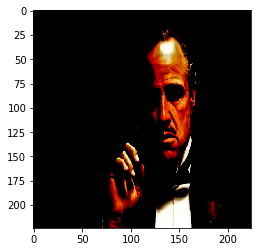

In [80]:
#Below is the actual image
plt.imshow(X_train[n])

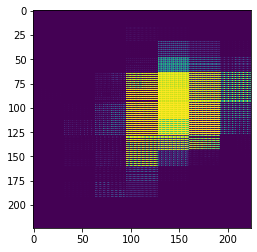

In [81]:
# Predicted mask for the above image, we can see the mask (in yellow) at the face.
plt.imshow(preds_train[n])

### Impose the mask on the image (5 marks)


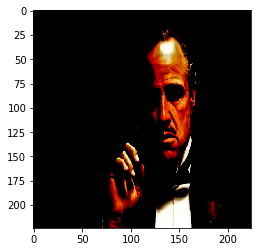

In [107]:
# Before imposing mask over the image, saving the actual image and predicted mask to drive PredImg1.png and ActImg1.png
MaskImg1= plt.imshow(preds_train[n])
MaskImg1.figure.savefig('PredImg1.png')

TrainImg1= plt.imshow(X_train[n])
TrainImg1.figure.savefig('ActImg1.png')

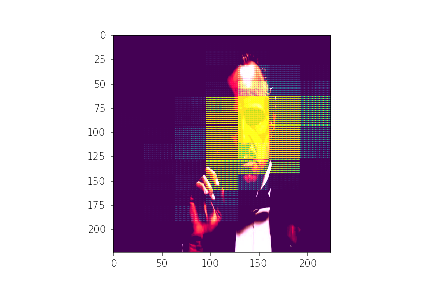

In [108]:
from google.colab.patches import cv2_imshow

# Load masked image to background variable
background = cv2.imread('PredImg1.png', 1) 
  
# Load actual image to background variable
overlay = cv2.imread('ActImg1.png', 1) 
  
# Add both the images (imposing mask over the actual)
img = cv2.add(overlay, background) 
  
# Show the image 
cv2_imshow(img) 

cv2.waitKey(0) # wait for user pressing a key
cv2.destroyAllWindows() # Close the window

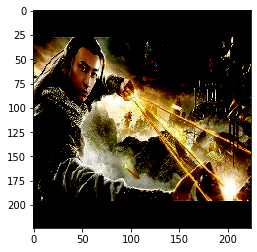

In [110]:
n=21
# Before imposing mask over the image, saving the actual image and predicted mask to drive PredImg1.png and ActImg1.png
MaskImg2= plt.imshow(preds_train[n])
MaskImg2.figure.savefig('PredImg2.png')

TrainImg2= plt.imshow(X_train[n])
TrainImg2.figure.savefig('ActImg2.png')

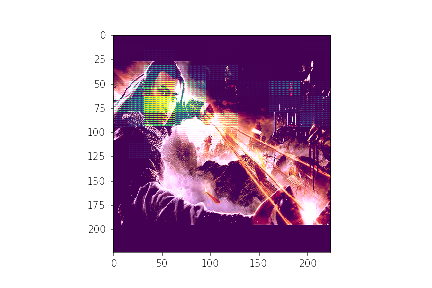

In [111]:
from google.colab.patches import cv2_imshow
# Load masked image to background variable
background = cv2.imread('PredImg2.png', 1) 
  
# Load actual image to background variable
overlay = cv2.imread('ActImg2.png', 1) 
  
# Add both the images (imposing mask over the actual)
img = cv2.add(overlay, background) 
  
# Show the image 
cv2_imshow(img) 

cv2.waitKey(0) # wait for user pressing a key
cv2.destroyAllWindows() # Close the window